# Proyecto Geofísica

El proyecto de geofísica tiene tres partes:

1.	MiniSEED real → cargar y procesar un sismograma (filtros + espectrograma).
2.	Catálogo real USGS → leer terremotos en España (2016–2020) y hacer un mapa de epicentros con Cartopy.
3.	Ejemplo de mecanismo focal → beachball del terremoto de Granada (2021).




## 1. Cargar y  y procesar un sismograma 

0. Para esto vamos a necesitar utilizar el paquete ObsPy, así que necesitamos tener instalado el paquete ObsPy (pip install obspy)

1. Leer datos sísmicos (ObsPy)
	•	Formato habitual: MiniSEED (.mseed).
	•	Se carga con read() de ObsPy.


In [3]:
pip install obspy # instala la librería obspy

Note: you may need to restart the kernel to use updated packages.


### Ejemplo que funciona casi siempre

Vamos a bajar un evento global (Mw 7.1 México, 2017-09-19) con la estación global IU.ANMO (Albuquerque, USA). Esa estación casi siempre tiene datos.

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

# Evento: Mw 7.1 México, 19 Sept 2017
t_inicio = UTCDateTime("2017-09-19T18:14:00")
t_fin    = t_inicio + 1800   # 30 min de señal

# Estación global muy fiable
st = client.get_waveforms(
    network="IU", station="ANMO", location="00", channel="BHZ",
    starttime=t_inicio, endtime=t_fin
)

# Guardar en MiniSEED
st.write("sismo.mseed", format="MSEED")
print(st)

1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2017-09-19T18:14:00.019536Z - 2017-09-19T18:43:59.969536Z | 20.0 Hz, 36000 samples


### Importamos las librerías necesarias

 *   numpy: para el manejo de arrays y matrices
 *   matplotlib: para la visualización
 *   obspy: para el procesamiento de sismogramas


Para no tener que depender de internet. He añadido el fichero sismo.mseed en la carpeta data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

st = read("data/sismo.mseed")
print(st)

1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2017-09-19T18:14:00.019536Z - 2017-09-19T18:43:59.969536Z | 20.0 Hz, 36000 samples


In [9]:
tr = st[0]  # tomar la primera traza

print(tr.stats)   # metadatos: estación, canal, muestreo, etc.

         network: IU
         station: ANMO
        location: 00
         channel: BHZ
       starttime: 2017-09-19T18:14:00.019536Z
         endtime: 2017-09-19T18:43:59.969536Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 36000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 152, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 77824})


### Graficamos la señal cruda

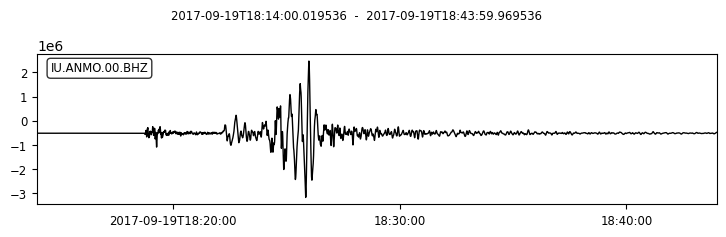

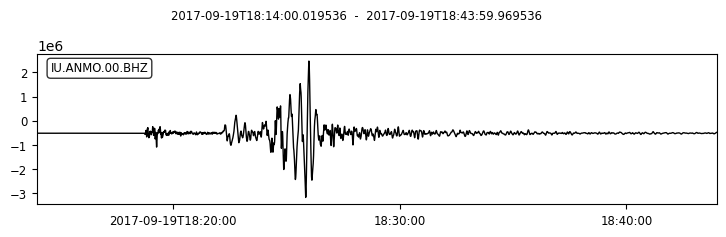

In [11]:
tr.plot()

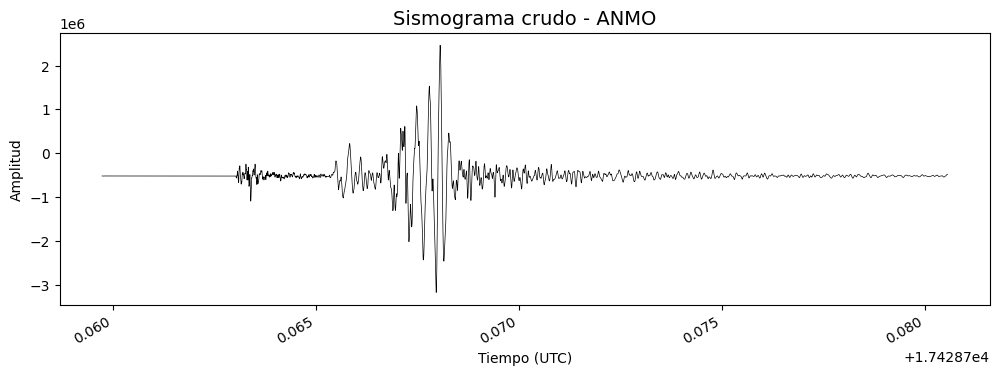

In [10]:
# --- 2. Graficar la señal cruda ---
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(tr.times("matplotlib"), tr.data, "k-", linewidth=0.5)
ax.set_title(f"Sismograma crudo - {tr.stats.station}", fontsize=14)
ax.set_xlabel("Tiempo (UTC)")
ax.set_ylabel("Amplitud")
fig.autofmt_xdate()
plt.show()

### Procesado estándar 

1. Hacemos una copia del original para no modificarlo
2. Quitamos la tendencia lineal y el offset
3. Aplicamos lo que se conoce como taper, es decir, aplicamos una ventana para evitar artefactos
4. Aplicamos un filtro pasa-banda 1–10 Hz (ajustable según datos)
5. Creamos el eje de tiempo en segundos desde el inicio del evento
6. Normalizamos la amplitud para que todos los valores estén entre 1 y -1

In [12]:
# --- 2. Preprocesado estándar ---
tr_proc = tr.copy()

# Quitar tendencia (lineal) y offset medio
tr_proc.detrend("linear")
tr_proc.detrend("demean")

# Aplicar taper (ventana para evitar artefactos en extremos)
tr_proc.taper(max_percentage=0.05, type="cosine")

# Filtro pasa-banda 1–10 Hz (ajustable según datos)
tr_proc.filter("bandpass", freqmin=1.0, freqmax=10.0, corners=4, zerophase=True)

# --- 3. Crear eje de tiempo en segundos desde el inicio ---
npts = tr_proc.stats.npts
dt = tr_proc.stats.delta  # intervalo de muestreo
t = np.linspace(0, npts*dt, npts)

# --- 4. Normalizar amplitud ---
data_norm = tr_proc.data / np.max(np.abs(tr_proc.data))

/Users/galeanojav/miniconda3/lib/python3.12/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


### Grafica del sismograma filtrado

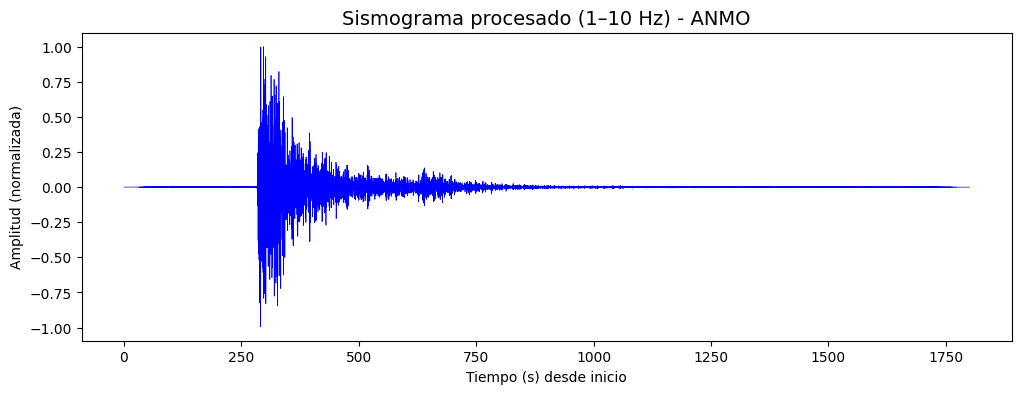

In [13]:
# --- 5. Graficar ---
plt.figure(figsize=(12,4))
plt.plot(t, data_norm, "b-", linewidth=0.5)
plt.title(f"Sismograma procesado (1–10 Hz) - {tr_proc.stats.station}", fontsize=14)
plt.xlabel("Tiempo (s) desde inicio")
plt.ylabel("Amplitud (normalizada)")
plt.show()

### Graficamos el Espectrograma 

Primero vamos a graficar en crudo (sobre datos filtrados) y luego algo más bonito

<Figure size 1000x600 with 0 Axes>

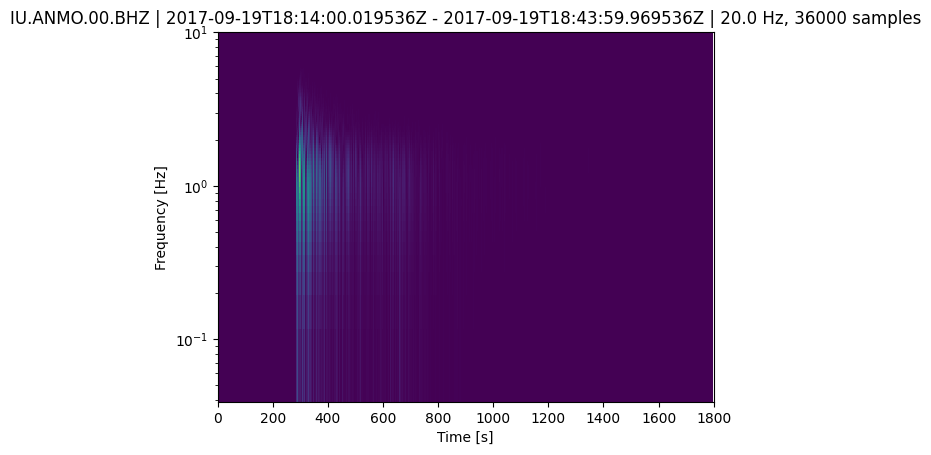

In [14]:
# --- 4. Espectrograma ---
fig = plt.figure(figsize=(10,6))

tr_proc.spectrogram(
    log=True,      # escala logarítmica en amplitud
    wlen=2.0,      # ventana de 2 segundos
    cmap="viridis"
)
plt.show()

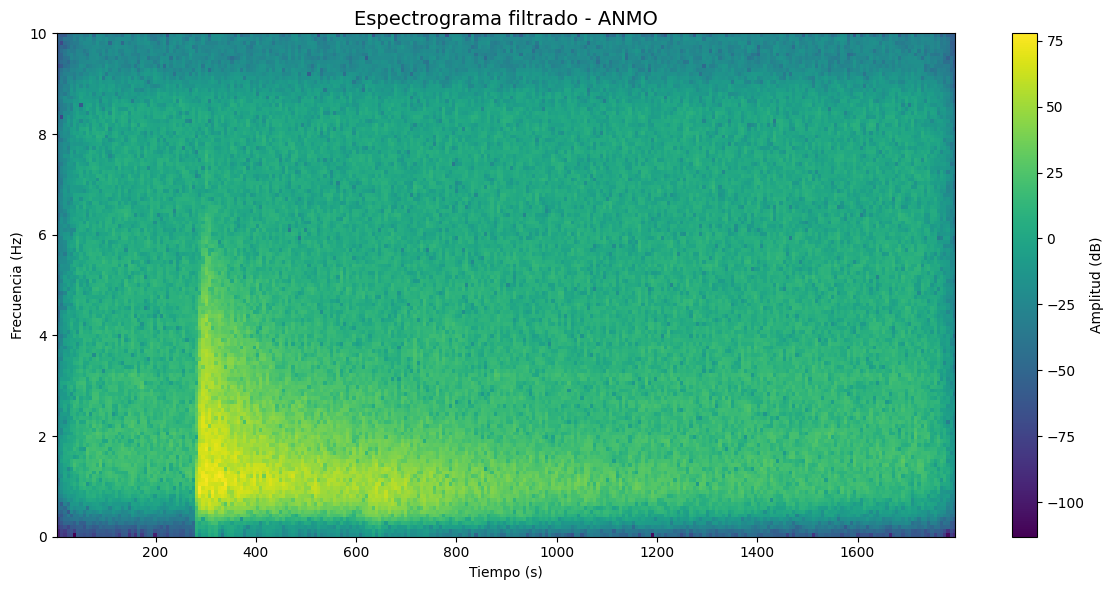

In [15]:
from matplotlib import mlab

nfft = 256                    # tamaño de ventana FFT
fs = tr_proc.stats.sampling_rate  # frecuencia de muestreo (Hz)

plt.figure(figsize=(12,6))
Pxx, freqs, bins, im = plt.specgram(
    tr_proc.data, NFFT=nfft, Fs=fs,
    noverlap=nfft//2, cmap="viridis",
    scale="dB"
)

plt.title(f"Espectrograma filtrado - {tr_proc.stats.station}", fontsize=14)
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.ylim(0, 10)   # limitar a 0–20 Hz, rango sísmico más interesante
cbar = plt.colorbar(im)
cbar.set_label("Amplitud (dB)")
plt.tight_layout()
plt.show()

## 2. Pintar un mapa con los epicentros de los terremotos

Pedimos a la UGSS el catálogo de terremotos de España de 2016 a 2020020, M>=4

In [16]:
import requests
import pandas as pd

# URL del catálogo USGS (España 2016–2020, M>=4)
url = (
    "https://earthquake.usgs.gov/fdsnws/event/1/query?"
    "format=geojson&starttime=2016-01-01&endtime=2020-12-31"
    "&minlatitude=35&maxlatitude=45&minlongitude=-10&maxlongitude=5"
    "&minmagnitude=4"
)

# Descargar JSON
resp = requests.get(url)
data = resp.json()

# Extraer datos
records = []
for feat in data["features"]:
    props = feat["properties"]
    coords = feat["geometry"]["coordinates"]
    records.append({
        "time": pd.to_datetime(props["time"], unit="ms"),
        "place": props["place"],
        "magnitude": props["mag"],
        "longitude": coords[0],
        "latitude": coords[1],
        "depth_km": coords[2],
    })

cat = pd.DataFrame(records)
print(cat.head())
print(f"Total de terremotos encontrados: {len(cat)}")

# Guardar catálogo en un CSV
cat.to_csv("data/catalogo_sismos_es_2016_2020.csv", index=False)

                     time                             place  magnitude  \
0 2020-12-08 16:35:41.871      209 km S of Sagres, Portugal        4.5   
1 2020-10-01 00:21:38.037  3 km NNE of Huarte-Uharte, Spain        4.4   
2 2020-09-30 22:02:31.047  3 km ESE of Huarte-Uharte, Spain        4.6   
3 2020-09-06 11:56:23.041       3 km SE of Tétouan, Morocco        4.3   
4 2020-08-13 08:04:48.379       4 km SSE of Chiffa, Algeria        4.4   

   longitude  latitude  depth_km  
0    -9.2935   35.1430      10.0  
1    -1.5713   42.8547      10.0  
2    -1.5515   42.8163      10.0  
3    -5.3362   35.5541      10.0  
4     2.7574   36.4252      10.0  
Total de terremotos encontrados: 87


Igual que antes para no depender de internet, guardamos el fichero  csv con los datos en la carpeta data

In [17]:
import pandas as pd

cat = pd.read_csv("data/catalogo_sismos_es_2016_2020.csv", parse_dates=["time"])
print(cat.head())

                     time                             place  magnitude  \
0 2020-12-08 16:35:41.871      209 km S of Sagres, Portugal        4.5   
1 2020-10-01 00:21:38.037  3 km NNE of Huarte-Uharte, Spain        4.4   
2 2020-09-30 22:02:31.047  3 km ESE of Huarte-Uharte, Spain        4.6   
3 2020-09-06 11:56:23.041       3 km SE of Tétouan, Morocco        4.3   
4 2020-08-13 08:04:48.379       4 km SSE of Chiffa, Algeria        4.4   

   longitude  latitude  depth_km  
0    -9.2935   35.1430      10.0  
1    -1.5713   42.8547      10.0  
2    -1.5515   42.8163      10.0  
3    -5.3362   35.5541      10.0  
4     2.7574   36.4252      10.0  


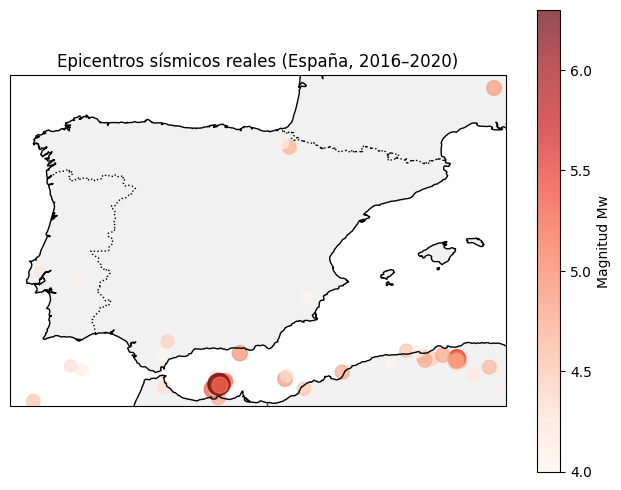

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(
    figsize=(8,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

sc = ax.scatter(
    cat["longitude"], cat["latitude"],
    s=cat["magnitude"]**3, 
    c=cat["magnitude"], cmap="Reds", alpha=0.7,
    transform=ccrs.PlateCarree()
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
ax.set_title("Epicentros sísmicos reales (España, 2016–2020)")

cbar = plt.colorbar(sc, ax=ax, orientation="vertical")
cbar.set_label("Magnitud Mw")

plt.show()

## 3. Pintamos los mecanismos focales

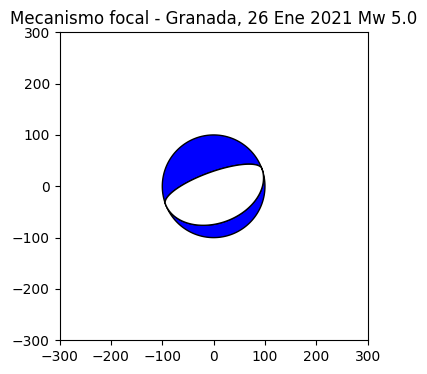

In [19]:
from obspy.imaging.beachball import beach
import matplotlib.pyplot as plt

# Mecanismo focal del terremoto de Granada (USGS)
# Strike, Dip, Rake
focmec = [250, 65, -90]

fig, ax = plt.subplots(figsize=(4,4))

b = beach(focmec, xy=(0,0), width=200, linewidth=1)
ax.add_collection(b)

ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
ax.set_aspect("equal")
ax.set_title("Mecanismo focal - Granada, 26 Ene 2021 Mw 5.0", fontsize=12)
plt.show()

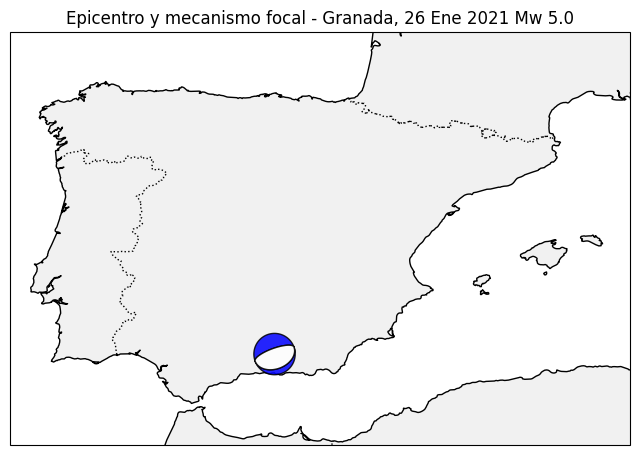

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordenadas del epicentro (aprox)
lon, lat = -3.6, 37.2

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())

# Dibujar el beachball en el mapa
b = beach(focmec, xy=(lon, lat), width=1.0, linewidth=1,
          facecolor="b", edgecolor="k", alpha=0.85,
          size=40)  # size controla el símbolo
ax.add_collection(b)

ax.set_title("Epicentro y mecanismo focal - Granada, 26 Ene 2021 Mw 5.0")
plt.show()